In [82]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import os
from tqdm import tqdm

# Read in Citibike stations.

We will use this shapefile to lookup neighborhood codes by station id.

In [70]:
input_dir = join("data", "citibike_stations_spatial_join_neighborhood")
input_filename = "citibike_stations_spatial_join_neighborhood.shp"
stations = gpd.read_file(join(input_dir, input_filename))

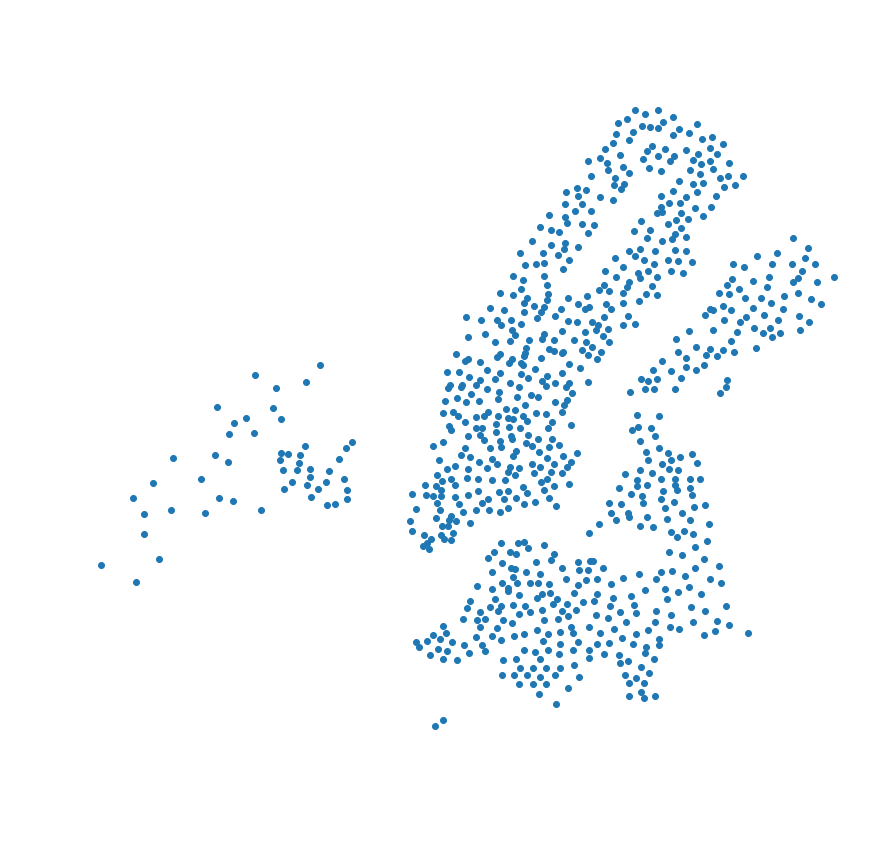

Citibike Stations


In [71]:
f, ax = plt.subplots(1, figsize=(15,15))
stations.plot(ax=ax, )
ax.set_axis_off()
plt.axis('equal')
plt.show()
print("Citibike Stations")

In [72]:
stations.head()

,id,name,test,docks,index_righ,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape_Leng,Shape_Area,geometry
0,72,W 52 St & 11 Ave,0,39,70,1,Manhattan,061,MN15,Clinton,35037.171670,1.838139e+07,POINT (-73.99392888 40.76727216)
1,79,Franklin St & W Broadway,0,33,101,1,Manhattan,061,MN24,SoHo-TriBeCa-Civic Center-Little Italy,26854.636018,2.503262e+07,POINT (-74.00666661 40.71911552)
2,82,St James Pl & Pearl St,0,27,114,1,Manhattan,061,MN27,Chinatown,20786.256014,1.450187e+07,POINT (-74.00016545 40.71117416)
3,83,Atlantic Ave & Fort Greene Pl,0,62,47,3,Brooklyn,047,BK68,Fort Greene,19825.520886,1.648282e+07,POINT (-73.97632328 40.68382604)
4,119,Park Ave & St Edwards St,0,19,47,3,Brooklyn,047,BK68,Fort Greene,19825.520886,1.648282e+07,POINT (-73.97803415 40.69608941)


# Read in Neighborhoods

In [79]:
input_dir = join("data", "nyc_and_jc_neighborhoods")
input_filename = "nyc_and_jc_neighborhoods.shp"
neighborhoods = gpd.read_file(join(input_dir, input_filename))

In [80]:
neighborhoods.head()

,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape_Leng,Shape_Area,geometry
0,3,Brooklyn,047,BK88,Borough Park,39247.228028,5.400502e+07,POLYGON ((-73.97604935657381 40.63127590564677...
1,4,Queens,081,QN52,East Flushing,25843.364936,2.945438e+07,POLYGON ((-73.79493246233996 40.75779803007455...
2,4,Queens,081,QN48,Auburndale,32446.878673,3.416422e+07,POLYGON ((-73.77573836927098 40.74332564716399...
3,4,Queens,081,QN51,Murray Hill,33266.904811,5.248828e+07,POLYGON ((-73.80379022888246 40.77561011179249...
4,4,Queens,081,QN27,East Elmhurst,19816.712323,1.972685e+07,"POLYGON ((-73.86109724335759 40.7636644770869,..."


# Create master departures dataframe

In [22]:
citibike_trips_path = join("data","citibike_trips")

In [23]:
departures = []

for i in tqdm(os.listdir(citibike_trips_path)):
    
    df = pd.read_csv(join(citibike_trips_path, i))
    df = pd.merge(df, stations[['id', 'BoroName','NTACode', 'NTAName']],
                     how='left', left_on='start_station_id', right_on='id')
    departure_df = df[['starttime', 'start_station_id', 'start_station_latitude',
                  'start_station_longitude', 'BoroName','NTACode', 'NTAName']]
    departures.append(departure_df)

100%|██████████| 30/30 [01:52<00:00,  3.74s/it]


In [24]:
%%time
departures = pd.concat(departures)

CPU times: user 1.48 s, sys: 1.41 s, total: 2.89 s
Wall time: 3.23 s


In [ ]:
%%time
departures['starttime'] = pd.to_datetime(departures['starttime'])

In [25]:
departures.shape

(19242375, 7)

Deal with NaNs.

In [94]:
departures_with_nans = departures[departures['NTACode'].astype(str) == "nan"].copy()

# Add spatial reference to dataframe
geometry = [Point(xy) for xy in zip(departures_with_nans.start_station_longitude, departures_with_nans.start_station_latitude)]
crs = {'init': 'epsg:4326'}
departures_with_nans = gpd.GeoDataFrame(departures_with_nans, crs=crs, geometry=geometry)

In [95]:
departures_with_nans = gpd.sjoin(departures_with_nans, neighborhoods, how="left", op='within')

In [96]:
del departures_with_nans['BoroName_left']
del departures_with_nans['NTACode_left']
del departures_with_nans['NTAName_left']
del departures_with_nans['index_right']
del departures_with_nans['Shape_Leng']
del departures_with_nans['Shape_Area']
del departures_with_nans['geometry']
del departures_with_nans['BoroCode']
del departures_with_nans['CountyFIPS']

In [97]:
departures_with_nans.rename(columns={'BoroName_right': 'BoroName', 'NTACode_right': 'NTACode', 'NTAName_right': 'NTAName'},
                            inplace=True)

In [98]:
# drop nans
departures = departures.dropna(subset=['NTACode'])

In [100]:
# add the spatially joined nan's back in
departures = pd.concat([departures, departures_with_nans])

In [101]:
departures.head()

,starttime,start_station_id,start_station_latitude,start_station_longitude,BoroName,NTACode,NTAName
0,2017-01-01 00:21:32,3276,40.714584,-74.042817,Jersey City,JC,Jersey City
1,2017-01-01 00:24:35,3183,40.716247,-74.033459,Jersey City,JC,Jersey City
2,2017-01-01 00:38:19,3183,40.716247,-74.033459,Jersey City,JC,Jersey City
3,2017-01-01 00:38:37,3194,40.725340,-74.067622,Jersey City,JC,Jersey City
4,2017-01-01 01:47:52,3183,40.716247,-74.033459,Jersey City,JC,Jersey City


In [102]:
departures.shape

(19242375, 7)

In [103]:
%%time
output_dir = join("data", "citibike_departures")
output_filename = "citibike_departures.csv"
# Make data directory
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
departures.to_csv(join(output_dir, output_filename))

CPU times: user 2min 10s, sys: 2.82 s, total: 2min 13s
Wall time: 2min 14s


# Create master arrivals dataframe

In [33]:
arrivals = []

for i in tqdm(os.listdir(citibike_trips_path)):
    
    df = pd.read_csv(join(citibike_trips_path, i))
    df = pd.merge(df, stations[['id', 'BoroName','NTACode', 'NTAName']],
                     how='left', left_on='end_station_id', right_on='id')
    arrivals_df = df[['stoptime', 'end_station_id', 'end_station_latitude',
                  'end_station_longitude', 'BoroName','NTACode', 'NTAName']]
    arrivals.append(arrivals_df)

100%|██████████| 30/30 [01:47<00:00,  3.59s/it]


In [34]:
%%time
arrivals = pd.concat(arrivals)

CPU times: user 1.44 s, sys: 1.09 s, total: 2.53 s
Wall time: 2.65 s


In [105]:
arrivals_with_nans = arrivals[arrivals['NTACode'].astype(str) == "nan"].copy()

# Add spatial reference to dataframe
geometry = [Point(xy) for xy in zip(arrivals_with_nans.end_station_longitude,
                                    arrivals_with_nans.end_station_latitude)]
crs = {'init': 'epsg:4326'}
arrivals_with_nans = gpd.GeoDataFrame(arrivals_with_nans, crs=crs, geometry=geometry)

In [106]:
arrivals_with_nans = gpd.sjoin(arrivals_with_nans, neighborhoods, how="left", op='within')

In [107]:
del arrivals_with_nans['BoroName_left']
del arrivals_with_nans['NTACode_left']
del arrivals_with_nans['NTAName_left']
del arrivals_with_nans['index_right']
del arrivals_with_nans['Shape_Leng']
del arrivals_with_nans['Shape_Area']
del arrivals_with_nans['geometry']
del arrivals_with_nans['BoroCode']
del arrivals_with_nans['CountyFIPS']

In [108]:
arrivals_with_nans.rename(columns={'BoroName_right': 'BoroName', 'NTACode_right': 'NTACode', 'NTAName_right': 'NTAName'},
                            inplace=True)

In [109]:
# drop nans
arrivals = arrivals.dropna(subset=['NTACode'])

In [110]:
# add the spatially joined nan's back in
arrivals = pd.concat([arrivals, arrivals_with_nans])

In [111]:
arrivals.head()

,stoptime,end_station_id,end_station_latitude,end_station_longitude,BoroName,NTACode,NTAName
0,2017-01-01 00:24:01,3185,40.717732,-74.043845,Jersey City,JC,Jersey City
1,2017-01-01 00:45:58,3198,40.748716,-74.040443,Jersey City,JC,Jersey City
2,2017-01-01 00:44:31,3211,40.721525,-74.046305,Jersey City,JC,Jersey City
3,2017-01-01 01:03:50,3271,40.692640,-74.088012,Jersey City,JC,Jersey City
4,2017-01-01 01:58:31,3203,40.727596,-74.044247,Jersey City,JC,Jersey City


In [112]:
arrivals.shape

(19242375, 7)

In [113]:
%%time
output_dir = join("data", "citibike_arrivals")
output_filename = "citibike_arrivals.csv"
# Make data directory
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
arrivals.to_csv(join(output_dir, output_filename))

CPU times: user 1min 54s, sys: 2.7 s, total: 1min 56s
Wall time: 1min 58s


# Count hourly departures (with time lags) by neighborhood

In [119]:
departures = departures.dropna(subset=['BoroName', 'NTACode', 'NTAName'])

In [207]:
unique_origin_neighborhoods_in_departures = list(np.unique(departures['NTACode'].values))

In [214]:
departures_by_neighborhood_lagged = []

num_lagging_periods = 24 * 7

for n in tqdm(unique_origin_neighborhoods_in_departures):
    subset = departures[departures['NTACode'] == n].copy()
    subset_hourly = subset.resample('H', on='starttime').count()[['starttime']].reindex(hour_range).fillna(0)
    subset_hourly.columns = [n]
    for i in range(1, num_lagging_periods+1):
        column_name = '{}_t-{}'.format(n, i)
        subset_hourly[column_name] = subset_hourly[n].shift(i)
    departures_by_neighborhood_lagged.append(subset_hourly)

100%|██████████| 52/52 [01:20<00:00,  1.56s/it]


In [215]:
departures_by_neighborhood_lagged = pd.concat(departures_by_neighborhood_lagged, axis=1)

In [230]:
departures_by_neighborhood_lagged.dropna(inplace=True)

In [231]:
%%time
departures_by_neighborhood_lagged.to_csv(join("data", "citibike_departures", "citibike_departures_lags.csv"))

# Count hourly arrivals (with timelags) by Neighborhood

In [221]:
arrivals = arrivals.dropna(subset=['BoroName', 'NTACode', 'NTAName'])
unique_origin_neighborhoods_in_arrivals = list(np.unique(arrivals['NTACode'].values))

In [222]:
%%time
arrivals['stoptime'] = pd.to_datetime(arrivals['stoptime'])

CPU times: user 219 ms, sys: 258 ms, total: 477 ms
Wall time: 477 ms


In [223]:
arrivals_by_neighborhood_lagged = []

for n in tqdm(unique_origin_neighborhoods_in_arrivals):
    subset = arrivals[arrivals['NTACode'] == n].copy()
    subset_hourly = subset.resample('H', on='stoptime').count()[['stoptime']].reindex(hour_range).fillna(0)
    subset_hourly.columns = [n]
    for i in range(1, num_lagging_periods+1):
        column_name = '{}_t-{}'.format(n, i)
        subset_hourly[column_name] = subset_hourly[n].shift(i)
    arrivals_by_neighborhood_lagged.append(subset_hourly)

100%|██████████| 52/52 [01:23<00:00,  1.61s/it]


In [224]:
arrivals_by_neighborhood_lagged = pd.concat(arrivals_by_neighborhood_lagged, axis=1)
arrivals_by_neighborhood_lagged.dropna(inplace=True)

In [226]:
%%time
arrivals_by_neighborhood_lagged.to_csv(join("data", "citibike_arrivals", "citibike_arrivals_lags.csv"))

# Model # 1: Forecast Hourly Departures

In [235]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation

import matplotlib.pyplot as plt
import seaborn as sns
import math

In [236]:
departures_by_neighborhood_lagged.head()

,BK09,BK09_t-1,BK09_t-2,BK09_t-3,BK09_t-4,BK09_t-5,BK09_t-6,BK09_t-7,BK09_t-8,BK09_t-9,...,QN99_t-159,QN99_t-160,QN99_t-161,QN99_t-162,QN99_t-163,QN99_t-164,QN99_t-165,QN99_t-166,QN99_t-167,QN99_t-168
2017-01-08 00:00:00,2,1.0,0.0,2.0,1.0,0.0,2.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-08 01:00:00,0,2.0,1.0,0.0,2.0,1.0,0.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-08 02:00:00,0,0.0,2.0,1.0,0.0,2.0,1.0,0.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-08 03:00:00,0,0.0,0.0,2.0,1.0,0.0,2.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-08 04:00:00,0,0.0,0.0,0.0,2.0,1.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [237]:
# Feature variables
feature_columns = [i for i in departures_by_neighborhood_lagged.columns if '_t-' in i]
X = departures_by_neighborhood_lagged[feature_columns]

# Target variables
target_columns = [i for i in departures_by_neighborhood_lagged.columns if '_t-' not in i]
y = departures_by_neighborhood_lagged[target_columns]

# Reshape to arrays
X = np.array(X)

num_targets = len(target_columns)
y = np.array(y).reshape((len(y), num_targets))

In [238]:
X.shape

(10752, 8736)

In [239]:
y.shape

(10752, 52)

### Split into training and testing data

In [240]:
n_train_rows = 365 * 24

X_train = X[0 : n_train_rows, ]
X_test = X[n_train_rows:, ]

y_train = y[0 : n_train_rows]
y_test = y[n_train_rows:]

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.fit_transform(X_test)
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.fit_transform(y_test)

# Reshape
X_train = X_train.reshape(X_train.shape + (1,))
X_test = X_test.reshape(X_test.shape + (1,))

In [241]:
X_train.shape

(8760, 8736, 1)

In [242]:
y_train.shape

(8760, 52)

In [243]:
X_test.shape

(1992, 8736, 1)

In [244]:
y_test.shape

(1992, 52)

### LSTM

In [246]:
seed = 7
np.random.seed(seed)

In [ ]:
model = Sequential()
model.add(LSTM(10, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
#model.add(Dense(100, activation='linear'))
#model.add(LSTM(100))
model.add(Dense(num_targets, activation='linear'))

model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(X_train, y_train, epochs=10, batch_size=50,
                    validation_data=(X_test, y_test), verbose=2, shuffle=False)

Train on 8760 samples, validate on 1992 samples
Epoch 1/10


In [ ]:
history_loss = pd.DataFrame()
history_loss['train'] = history.history['loss']
history_loss['test'] = history.history['val_loss']
history_loss.plot(figsize=(10,10), fontsize=16,
                title='LSTM Model Loss');

In [ ]:
yhat = model.predict(X_test)
yhat = scaler_y.inverse_transform(np.array(yhat).reshape((len(yhat), num_targets)))
actual = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), num_targets)))

In [ ]:
results = pd.DataFrame()

#results['pred1'] = yhat[:,0]
#results['pred2'] = yhat[:,1]
#results['actual1'] = actual[:,0]
#results['actual2'] = actual[:,1]

#results[['pred1', 'actual1']].plot(figsize=(20,10))